# Load ds005514 and start training (see below to read presaved data)

In [ ]:
# This will be replace with one line of code with the EEGDashDataset object
# We need to resolve the binary labels -- Dung said there was a solution with Braindecode

import os
from eegdash import EEGDash
from eegdash.data_utils import EEGDashBaseRaw

eegdashdata = EEGDash(is_public=False)
records = eegdashdata.findrecord({'dataset': 'ds005514', 'task': 'RestingState'})
records = records[0:20]

print("number of records: ", len(records))
print("first record: ", records[0]) # current call

from braindecode.datasets import BaseDataset, BaseConcatDataset
gender_to_label = {'M': int(0), 'F': int(1)}

allEEGDash = []
for record in records:
    s3_path = eegdashdata.get_s3path(record)
    sfreq = record['sampling_frequency']
    nchans = record['nchans']
    ntimes = record['ntimes']
    ch_names = record['channel_names']
    ch_types = record['channel_types']
    s3_path = eegdashdata.get_s3path(record)
    eegdash = BaseDataset(EEGDashBaseRaw(s3_path, {'sfreq': sfreq, 'nchans': nchans, 'n_times': ntimes, 'ch_types': ch_types, 'ch_names': ch_names}, preload=False), target_name='genderbin')
    eegdash.set_description({'age': record['participantinfo']['age'], 'gender': record['participantinfo']['gender'], 'genderbin': gender_to_label[record['participantinfo']['gender']], 'subject': record['subject']})
    allEEGDash.append(eegdash)

eegdash_braindecode = BaseConcatDataset(allEEGDash)
eegdash_braindecode.description

number of records:  20
first record:  {'_id': ObjectId('6789a3c766ea5ef303140d0c'), 'data_name': 'ds005514_sub-NDARRW481GFE_task-RestingState_eeg.set', 'dataset': 'ds005514', 'bidspath': 'ds005514/sub-NDARRW481GFE/eeg/sub-NDARRW481GFE_task-RestingState_eeg.set', 'subject': 'NDARRW481GFE', 'task': 'RestingState', 'session': '', 'run': '', 'sampling_frequency': 500, 'modality': 'EEG', 'channel_names': ['E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'E10', 'E11', 'E12', 'E13', 'E14', 'E15', 'E16', 'E17', 'E18', 'E19', 'E20', 'E21', 'E22', 'E23', 'E24', 'E25', 'E26', 'E27', 'E28', 'E29', 'E30', 'E31', 'E32', 'E33', 'E34', 'E35', 'E36', 'E37', 'E38', 'E39', 'E40', 'E41', 'E42', 'E43', 'E44', 'E45', 'E46', 'E47', 'E48', 'E49', 'E50', 'E51', 'E52', 'E53', 'E54', 'E55', 'E56', 'E57', 'E58', 'E59', 'E60', 'E61', 'E62', 'E63', 'E64', 'E65', 'E66', 'E67', 'E68', 'E69', 'E70', 'E71', 'E72', 'E73', 'E74', 'E75', 'E76', 'E77', 'E78', 'E79', 'E80', 'E81', 'E82', 'E83', 'E84', 'E85', 'E86', 'E8

/Users/arno/Python/EEG-Dash-Data/.venv/lib/python3.11/site-packages/braindecode/datasets/base.py:131: UserWarning: 'genderbin' not in description. '__getitem__'will fail unless an appropriate target is added to description.
  warnings.warn(f"'{name}' not in description. '__getitem__'"


In [ ]:
from braindecode.preprocessing import (preprocess, Preprocessor, create_fixed_length_windows)

# Alternatively, if you want to include this as a preprocessing step in a Braindecode pipeline:
preprocessors = [
    Preprocessor('pick_channels', ch_names=['E22', 'E9', 'E33', 'E24', 'E11', 'E124', 'E122', 'E29', 'E6', 'E111', 'E45', 'E36', 'E104', 'E108', 'E42', 'E55', 'E93', 'E58', 'E52', 'E62', 'E92', 'E96', 'E70', 'Cz']),
    Preprocessor("resample", sfreq=128),
    Preprocessor("filter", l_freq=1, h_freq=55)
]
preprocess(eegdash_braindecode, preprocessors, n_jobs=-1) #, save_dir='xxxx'' will save and set preload to false

# extract windows and save to disk
windows_ds = create_fixed_length_windows(eegdash_braindecode, start_offset_samples=0, stop_offset_samples=None,
        window_size_samples=256, window_stride_samples=256, drop_last_window=True, preload=False) 
os.makedirs('data/hbn_preprocessed_restingstate', exist_ok=True)
windows_ds.save('data/hbn_preprocessed_restingstate', overwrite=True)

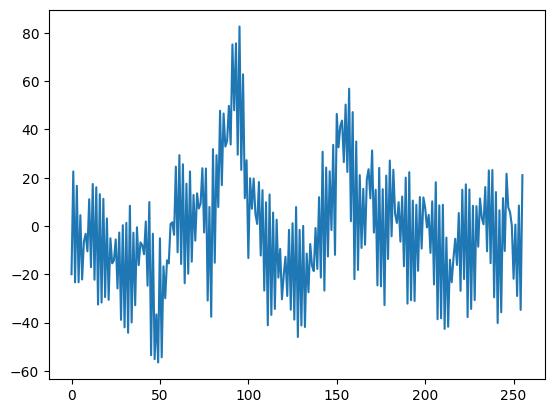

In [55]:
# ************
# ************
# ************
# INVESTIGATE WHY SOME CHANNEL HAVE STRONG NOISE, PROBABLY DUE TO FILTERING
# ************
# ************
# ************

import matplotlib.pyplot as plt
plt.figure()
plt.plot(windows_ds[1000][0][0,:].transpose()) # first channel of first epoch
plt.show()

# Start here to load presaved data

In [1]:
from braindecode.datautil import load_concat_dataset

print("Loading data from disk")
windows_ds = load_concat_dataset(path='data/hbn_preprocessed_restingstate', preload=False)


Loading data from disk


In [2]:
import torch
import numpy as np
from braindecode.datasets import BaseConcatDataset
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

random_state = 42
torch.manual_seed(random_state)
subject_genders = windows_ds.description['genderbin']

# Get balanced indices for male and female subjects
male_indices = np.where(subject_genders == 0)[0]
female_indices = np.where(subject_genders == 1)[0]
n_samples = min(len(male_indices), len(female_indices))
balanced_indices = np.concatenate([male_indices[:n_samples], female_indices[:n_samples]])
train_indices, test_indices = train_test_split(balanced_indices, test_size=0.2, stratify=subject_genders[balanced_indices], random_state=random_state)

# Create datasets and dataloaders for batch processing
train_ds = BaseConcatDataset([windows_ds.datasets[i] for i in train_indices])
test_ds = BaseConcatDataset([windows_ds.datasets[i] for i in test_indices])
train_loader = DataLoader(train_ds, batch_size=100, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=100, shuffle=True)

# Print shapes and sizes to verify split
print(f"Shape of data {train_ds[0][0].shape} number of samples - Train: {len(train_ds)}, Test: {len(test_ds)}")
print(f"Sex balance, train: {np.mean(train_ds.description['genderbin']):.2f}, test: {np.mean(test_ds.description['genderbin']):.2f}")

Shape of data (24, 256) number of samples - Train: 30239, Test: 7387
Sex balance, train: 0.50, test: 0.49


In [3]:
dataiter = iter(train_loader)
first_item, label, sz = dataiter.__next__() # question why is the label lost here 
label

tensor([0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1,
        1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0,
        0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0,
        0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1,
        0, 0, 1, 0])

In [4]:
# create model
from torchinfo import summary
from torch import nn

model = nn.Sequential(
    # First VGG block
    nn.Conv2d(1, 16, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(2, 2),
    
    # Second VGG block
    nn.Conv2d(16, 32, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(32, 32, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(2, 2),
    
    # Third VGG block
    nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(2, 2),
    
    # Flatten and FC layers
    nn.Flatten(),
    nn.Linear(64 * 3 * 32, 1024), nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, 1024), nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, 2)
)

print(summary(model, input_size=(1, 1, 24, 256)))


Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 2]                    --
├─Conv2d: 1-1                            [1, 16, 24, 256]          160
├─ReLU: 1-2                              [1, 16, 24, 256]          --
├─Conv2d: 1-3                            [1, 16, 24, 256]          2,320
├─ReLU: 1-4                              [1, 16, 24, 256]          --
├─MaxPool2d: 1-5                         [1, 16, 12, 128]          --
├─Conv2d: 1-6                            [1, 32, 12, 128]          4,640
├─ReLU: 1-7                              [1, 32, 12, 128]          --
├─Conv2d: 1-8                            [1, 32, 12, 128]          9,248
├─ReLU: 1-9                              [1, 32, 12, 128]          --
├─MaxPool2d: 1-10                        [1, 32, 6, 64]            --
├─Conv2d: 1-11                           [1, 64, 6, 64]            18,496
├─ReLU: 1-12                             [1, 64, 6, 64]            --
├

In [5]:

from torch.nn import functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
optimizer = torch.optim.Adamax(model.parameters(), lr=0.002, weight_decay=0.001)
model = model.to(device=device)  # move the model parameters to CPU/GPU

def normalize_data(x):
    x = x.reshape(x.shape[0], 1, 24, 256)
    mean = x.mean(dim=3, keepdim=True)
    std = x.std(dim=3, keepdim=True) + 1e-7  # add small epsilon for numerical stability
    x = (x - mean) / std
    x = x.to(device=device, dtype=torch.float32)  # move to device, e.g. GPU
    return x

epochs = 10
for e in range(epochs):
    
    # training
    results_train = np.array([])
    for t, (x, y, sz) in enumerate(train_loader):
        model.train()  # put model to training mode
        scores = model(normalize_data(x))
        loss = F.cross_entropy(scores, y.to(device=device, dtype=torch.long))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        results_train = np.concatenate((results_train, (scores.max(1).indices.cpu().numpy() == y)))

        if t % 100 == 0:
            print('Epoch %d, Iteration %d, loss = %.4f' % (e, t, loss.item()))
    
    # validation
    results_test = np.array([])
    for t, (x, y, sz) in enumerate(test_loader):
        model.eval()
        scores = model(normalize_data(x))
        results_test = np.concatenate((results_test, (scores.max(1).indices.cpu().numpy() == y)))

    print(f'Epoch {e}, Train accuracy: {np.mean(results_train):.2f}, Test accuracy: {np.mean(results_test):.2f}')


Epoch 0, Iteration 0, loss = 0.6944
Epoch 0, Iteration 100, loss = 0.5076
Epoch 0, Iteration 200, loss = 0.4964
Epoch 0, Iteration 300, loss = 0.4447
Epoch 0, Train accuracy: 0.70, Test accuracy: 0.60
Epoch 1, Iteration 0, loss = 0.4564
Epoch 1, Iteration 100, loss = 0.3445
Epoch 1, Iteration 200, loss = 0.3525
Epoch 1, Iteration 300, loss = 0.2774
Epoch 1, Train accuracy: 0.87, Test accuracy: 0.56
Epoch 2, Iteration 0, loss = 0.2690
Epoch 2, Iteration 100, loss = 0.1473
Epoch 2, Iteration 200, loss = 0.1865
Epoch 2, Iteration 300, loss = 0.0460
Epoch 2, Train accuracy: 0.93, Test accuracy: 0.54
Epoch 3, Iteration 0, loss = 0.0905


KeyboardInterrupt: 